# Verifying Volunteer Entries to the NYC Trees Census

To accomplish this, answer the following questions:
* What features are most important in determining the health of a tree?
    * Hypothesis: Neighborhood and problems in trunk, root, or branches will be the most important.
* Are there any features that may help in future censuses?
    * Hypothesis: Age of the tree would be a great variable to include.
* What do the numbers of entries for each class of tree health tell us about volunteer efforts?
    * Hypothesis: Volunteers tend to rate trees in better condition.
* Do maps shed any light on any issues with the census?
    
## Approach
Using NYC Open Datas's [2015 Street Tree Census Data Set](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35) (click **Export** to download a non-geospatial version of the dataset), I perform exploratory data analysis and feature engineering to find the significance of certain variables on the health of NYC street trees. I then create a classification model in the hopes of checking the likelihood of the veracity of the health status imputed by volunteers. Ultimately, my goal is to determine which features are most important to help my model, which information may be helpful for future censuses, and finally, creating a list of trees imputed by volunteers for which the health status does not match that of my model.

## Cleaning and exploring the data
* Import the necessary libraries.

In [354]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
import geopandas as gpd

import pickle

from functions import *
%load_ext autoreload
%autoreload 2

from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import itertools

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* Import the data and take a look.

In [359]:
trees_initial = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')
trees_initial.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [360]:
trees_initial.shape

(683788, 42)

In [361]:
trees_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

In [362]:
trees_initial.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424624
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153719
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252497
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571916
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092088


* Rename some columns.

In [363]:
trees_initial.columns = ['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'latitude',
       'longitude', 'x_sp', 'y_sp']

* Remove stumps and dead trees.

In [364]:
trees_initial.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [365]:
# Get indices of dead trees and stumps
dead = trees_initial[trees_initial.status.isin(['Dead', 'Stump'])].index
 
# Delete these row indices from dataFrame
trees_initial.drop(dead, inplace=True)

trees_initial.shape

(652173, 42)

* Drop some unneccesary columns and set the index to each tree's unique ID.

In [366]:
drop_cols = ['created_at', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'problems', 'address', 'zipcode',
             'zip_city', 'borocode', 'boro_ct', 'state', 'x_sp', 'y_sp']
trees_initial.drop(columns=drop_cols, inplace=True)
trees_initial.set_index(['tree_id'], inplace=True)
trees_initial.shape

(652173, 27)

* Save a copy.

In [367]:
# uncomment to save
# trees_initial.to_csv('data/nyc_trees_2015_initial_clean.csv')

In [368]:
trees = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)
trees.head()

,block_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,nta_name,latitude,longitude
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
200540,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
204026,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
204337,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
189565,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


## Feature engineering and EDA

* Look for NaN values.

In [369]:
trees.isna().sum()

block_id        0
tree_dbh        0
curb_loc        0
health          1
spc_common      5
steward         0
guards          1
sidewalk        1
user_type       0
root_stone      0
root_grate      0
root_other      0
trunk_wire      0
trunk_light     0
trunk_other     0
branch_light    0
branch_shoe     0
branch_other    0
cb_num          0
boroname        0
council_dist    0
st_assem        0
st_senate       0
nta             0
nta_name        0
latitude        0
longitude       0
dtype: int64

* Drop the few rows with missing values for our target variable and species of tree.

In [370]:
trees.dropna(how='any', axis=0, inplace=True)

* Create and pickle a dictionary of neighborhood codes and names, in case we want that later.

In [371]:
nta = list(trees['nta'].unique())

In [372]:
nta_name = list(trees['nta_name'].unique())

In [373]:
nta_dict = {k: v for k,v in zip(nta, nta_name)}

In [374]:
# with open('data/nta_dict.pickle', 'wb') as f:
#     pickle.dump(nta_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

* We want to build a model based on the professional entries, so let's drop all of the volunteer entries.
    * Before we do that, however, we want to create a variable to see if the amount of trees on a block has any relationship to the health of trees. Doing this before dropping volunteers give us the most accurate block count.

In [375]:
trees.block_id.value_counts().unique()

array([440, 356, 241, 206, 194, 176, 148, 145, 136, 124, 121, 118, 115,
       108, 104, 103, 102,  99,  96,  92,  91,  89,  88,  86,  85,  83,
        80,  78,  77,  76,  75,  74,  72,  71,  70,  69,  68,  67,  65,
        64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,
        51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [376]:
# create a column with the total count of the trees on that row's block
block_counts = trees.block_id.value_counts().rename('block_count')

# merge onto dataframe
trees = trees.merge(block_counts.to_frame(),
                                left_on='block_id',
                                right_index=True)

trees.block_count.unique()

array([ 15,  21,   4,  24,   5,   3,  14,  11,   7,  13,   8,  20,  12,
        16,  10,   2,   6,   9,  60,  19,  43,  18,  17,  27,   1,  42,
        29,  25,  46,  22,  23,  34,  26,  67,  72,  31, 103,  38,  41,
        49, 104, 440,  37,  32,  63,  28,  36,  69, 194,  53,  47,  35,
        48,  44,  33,  30, 136,  55,  39,  58,  45, 145,  77,  40,  68,
        50,  64,  99,  92,  62,  61,  59,  88, 124,  80,  52,  51,  83,
        74, 148, 241,  56,  75,  54,  57, 176,  70, 206, 356,  86,  78,
        71,  96, 108, 121,  89,  76,  85, 115, 118,  65, 102,  91])

In [377]:
trees.block_count.describe()

count    652166.000000
mean         12.376858
std          18.846467
min           1.000000
25%           5.000000
50%           9.000000
75%          15.000000
max         440.000000
Name: block_count, dtype: float64

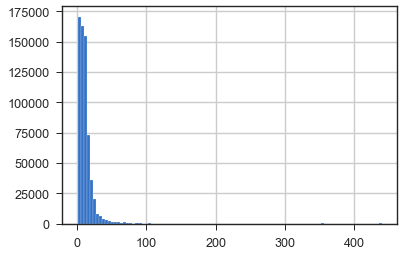

In [378]:
trees.block_count.hist(bins=100)

* Let's normalize the block count by taking the log.

In [379]:
trees['log_block_count'] = trees.block_count.apply(lambda x: np.log(x))

In [380]:
trees.log_block_count.describe()

count    652166.000000
mean          2.178280
std           0.778605
min           0.000000
25%           1.609438
50%           2.197225
75%           2.708050
max           6.086775
Name: log_block_count, dtype: float64

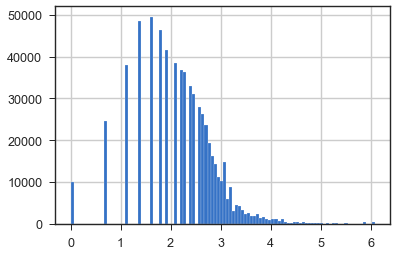

In [381]:
trees.log_block_count.hist(bins=100)

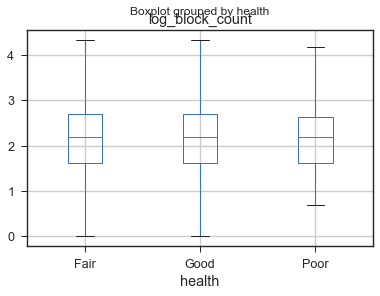

In [382]:
trees.boxplot('log_block_count', 'health', showfliers=False)

* Our new feature doesn't look too promising, but we'll see if reining in extreme values affects this a little later on.


* On to dropping those volunteers:
    * Notice too that volunteers tend to rate fewer trees as 'Good' and more as 'Fair'. Perhaps a result of lack of training.
    * And based on our maps (*see mapmaking notebook*), volunteers tended to not venture into the farther reaches of the city, which may skew their results.
    * Furthermore, one may assume a bias for volunteers tracking trees in their neighborhoods.

In [383]:
trees.user_type.value_counts()

TreesCount Staff    282254
Volunteer           207776
NYC Parks Staff     162136
Name: user_type, dtype: int64

In [385]:
trees.groupby('boroname').user_type.value_counts()

boroname       user_type       
Bronx          TreesCount Staff     45158
               NYC Parks Staff      22924
               Volunteer            12502
Brooklyn       Volunteer            74642
               TreesCount Staff     60594
               NYC Parks Staff      34507
Manhattan      Volunteer            41773
               TreesCount Staff     13715
               NYC Parks Staff       6939
Queens         TreesCount Staff    131917
               Volunteer            73150
               NYC Parks Staff      32903
Staten Island  NYC Parks Staff      64863
               TreesCount Staff     30870
               Volunteer             5709
Name: user_type, dtype: int64

* Volunteer data also seems very skewed by borough. Manhattan especially, followed by Brooklyn. Bronx and Staten Island are woefully underserved by volunteers. Taking just the professional datapoints should help keep our data more independent.

In [386]:
trees.groupby('user_type').health.value_counts(normalize=True)

user_type         health
NYC Parks Staff   Good      0.824314
                  Fair      0.131094
                  Poor      0.044592
TreesCount Staff  Good      0.814656
                  Fair      0.148069
                  Poor      0.037275
Volunteer         Good      0.795347
                  Fair      0.161020
                  Poor      0.043634
Name: health, dtype: float64

In [387]:
# Get indices of volunteer
volunteers = trees[trees.user_type == 'Volunteer'].index
 
# Delete these row indices from dataFrame
trees.drop(volunteers, inplace=True)

trees.shape

(444390, 29)

* Let's go ahead and drop some more unnecessary columns.
    * We will use latitude and longitude later, but we can drop it for this part of feature engineering.

In [388]:
trees.columns

Index(['block_id', 'tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward',
       'guards', 'sidewalk', 'user_type', 'root_stone', 'root_grate',
       'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'cb_num', 'boroname',
       'council_dist', 'st_assem', 'st_senate', 'nta', 'nta_name', 'latitude',
       'longitude', 'block_count', 'log_block_count'],
      dtype='object')

In [389]:
drop_cols = ['block_id', 'user_type', 'nta_name', 'latitude', 'longitude', 'block_count']
trees.drop(columns=drop_cols, inplace=True)
trees.shape

(444390, 23)

In [390]:
trees.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,...,branch_light,branch_shoe,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,log_block_count
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180679,3,OnCurb,Good,Callery pear,None,None,Damage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180669,12,OnCurb,Fair,crimson king maple,None,None,NoDamage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180677,13,OnCurb,Good,littleleaf linden,None,None,NoDamage,Yes,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805
180682,5,OnCurb,Fair,eastern redbud,None,None,NoDamage,No,No,No,...,No,No,No,406,Queens,29,28,16,QN17,2.70805


* Take a look at our target variable.

In [391]:
trees.health.value_counts()

Good    363591
Fair     63048
Poor     17751
Name: health, dtype: int64

In [392]:
trees.health.value_counts(normalize=True)

Good    0.818180
Fair    0.141875
Poor    0.039945
Name: health, dtype: float64

* Since we only have two continuous variables (tree diameter and block count), let's go ahead and rein in the extreme values on that now.

In [393]:
trees.tree_dbh.describe()

count    444390.000000
mean         11.908191
std           8.831671
min           0.000000
25%           5.000000
50%          10.000000
75%          17.000000
max         425.000000
Name: tree_dbh, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1385bcb38>]],
      dtype=object)

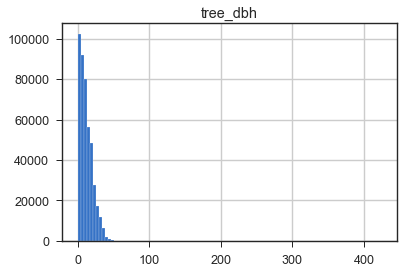

In [394]:
trees.hist('tree_dbh', bins=100)

In [395]:
rein_extremes(trees, ['tree_dbh', 'log_block_count'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1385a7668>]],
      dtype=object)

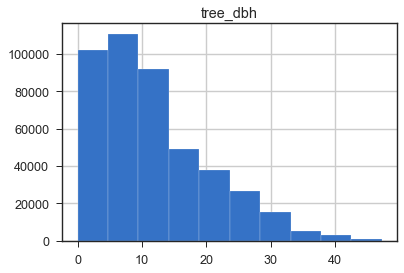

In [396]:
trees.hist('tree_dbh', bins=10)

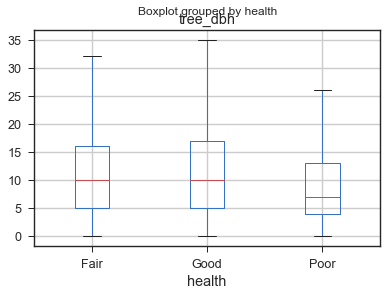

In [397]:
trees.boxplot('tree_dbh', 'health', showfliers=False)

* Tree diameter looks like a promising feature, as thinner trees tend to be in poor health as compared to thicker trees. Not much difference between trees in good and fair health, however.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a178080>]],
      dtype=object)

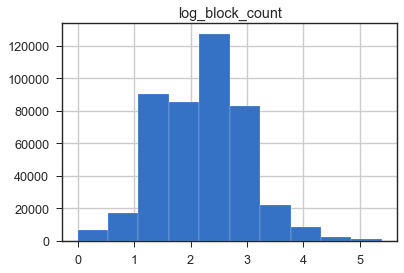

In [398]:
trees.hist('log_block_count', bins=10)

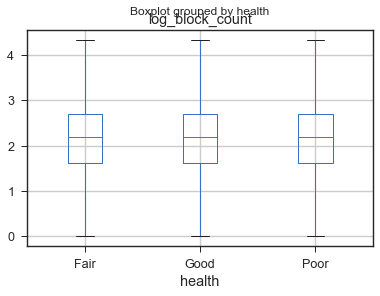

In [399]:
trees.boxplot('log_block_count', 'health', showfliers=False)

* We'll wait to see if this holds any interactive power in our models.

### EDA - Boroughs
* Take a look at the health of trees across the boroughs.

In [407]:
trees.boroname.value_counts()

Queens           164820
Staten Island     95733
Brooklyn          95101
Bronx             68082
Manhattan         20654
Name: boroname, dtype: int64

In [408]:
trees.groupby('boroname').health.value_counts()

boroname       health
Bronx          Good       57183
               Fair        8409
               Poor        2490
Brooklyn       Good       76921
               Fair       14375
               Poor        3805
Manhattan      Good       16084
               Fair        3420
               Poor        1150
Queens         Good      135189
               Fair       23364
               Poor        6267
Staten Island  Good       78214
               Fair       13480
               Poor        4039
Name: health, dtype: int64

In [409]:
trees.groupby('boroname').health.value_counts(normalize=True)

boroname       health
Bronx          Good      0.839914
               Fair      0.123513
               Poor      0.036574
Brooklyn       Good      0.808835
               Fair      0.151155
               Poor      0.040010
Manhattan      Good      0.778735
               Fair      0.165585
               Poor      0.055679
Queens         Good      0.820222
               Fair      0.141755
               Poor      0.038023
Staten Island  Good      0.817001
               Fair      0.140808
               Poor      0.042190
Name: health, dtype: float64

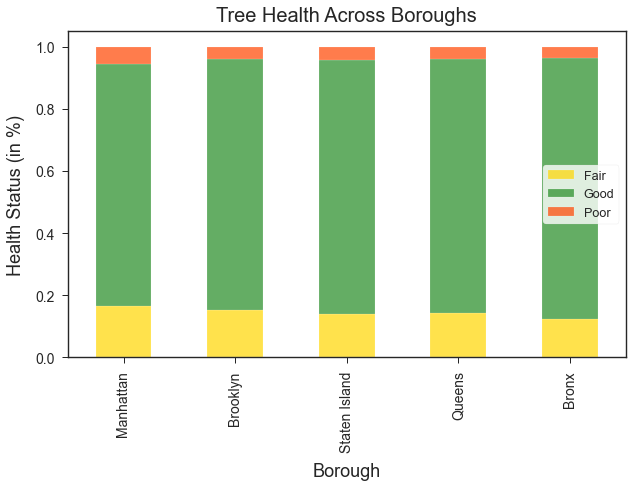

In [410]:
# sort by percentage of trees in good health
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p1 = boros.plot(kind = 'bar', stacked = True, figsize=(10,6),
#                    title = 'Tree Health Across Boroughs', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, fontsize=14)

p1.set_title('Tree Health Across Boroughs', fontsize=20, pad=10)
p1.set_xlabel('Borough', fontsize=18, labelpad=10)
p1.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p1.legend(['Fair','Good', 'Poor'])
plt.show()

* There does seem to be a difference between the boroughs, especially Manhattan from the rest.
* Let's do some statistical analyses.

In [411]:
# create a frequency table
df_boro_health = pd.crosstab(trees.health, trees.boroname)
df_boro_health

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,8409,14375,3420,23364,13480
Good,57183,76921,16084,135189,78214
Poor,2490,3805,1150,6267,4039


In [412]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_boro_health)
# p-value shows significance
p

3.530263683508544e-117

In [413]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table = sm.stats.Table(df_boro_health)
table.standardized_resids

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,-14.922137,9.250982,10.000898,-0.177116,-1.068283
Good,15.977694,-8.427983,-15.051476,2.710004,-1.067351
Poor,-4.881134,0.116258,11.825406,-5.021920,4.005638


In [414]:
# percentage of significant values
abs_table = table.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()) * 100, 2)}%')

73.33%


### EDA - Community Boards

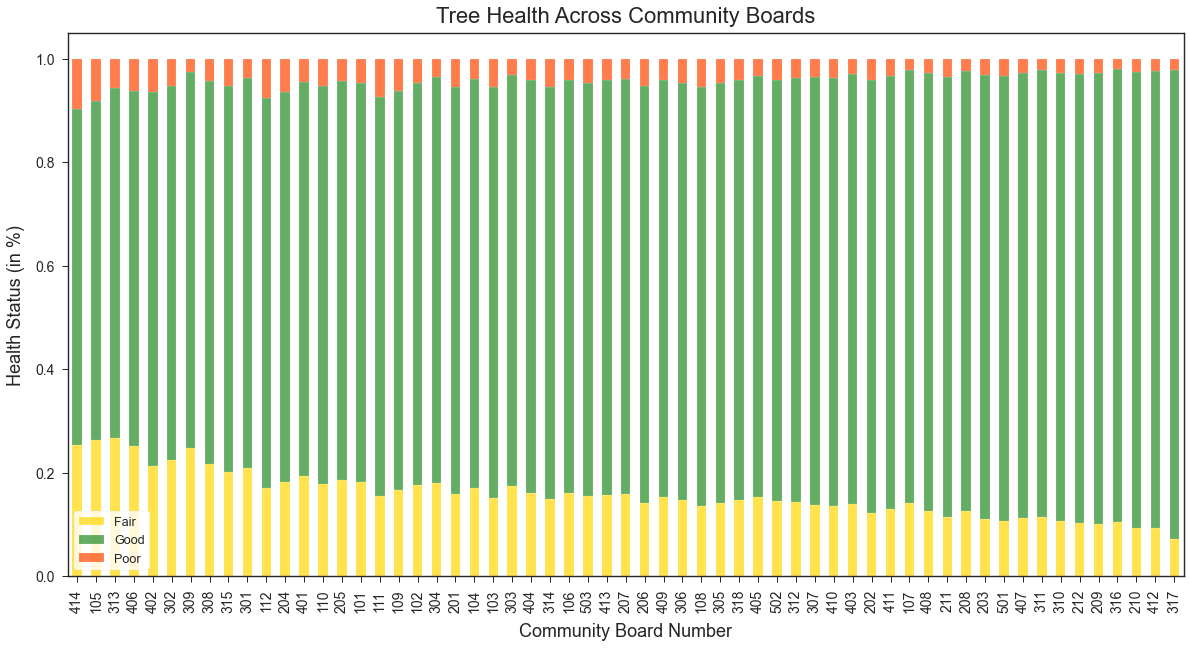

In [415]:
# sort by percentage of trees in good health
community_boards = trees.groupby(['cb_num']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p2 = community_boards.plot(kind = 'bar', stacked = True, figsize=(20,10),
#                    title = 'Tree Health Across Community Boards', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, fontsize=14)
p2.set_title('Tree Health Across Community Boards', fontsize=22, pad=10)
p2.set_xlabel('Community Board Number', fontsize=18, labelpad=10)
p2.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p2.legend(['Fair','Good', 'Poor'])
plt.show()

* There does seem to be a difference between most community board areas.
* Let's do some statistical analyses.

In [416]:
# create a frequency table
df_cb_health = pd.crosstab(trees.health, trees.cb_num)
df_cb_health

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,344,316,232,154,151,198,253,282,296,375,...,1940,1019,1780,2715,2082,4997,2438,2518,3291,7671
Good,1446,1395,1212,710,377,977,1495,1676,1375,1619,...,12952,5343,10898,17499,19767,25522,6231,20231,18306,39677
Poor,89,86,85,36,47,51,40,115,113,111,...,438,278,485,719,541,1314,933,809,910,2320


In [417]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_cb_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(142.13816003902645, 7345.570039622511)

In [418]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table2 = sm.stats.Table(df_cb_health)
table2.standardized_resids

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,5.129318,4.135827,1.106630,2.516209,8.302588,1.972131,-0.045719,-0.763919,2.916401,4.780778,...,-5.534750,2.726784,-2.219009,-5.172068,-21.514019,8.013637,31.807539,-15.816677,1.917722,8.518952
Good,-5.476062,-4.612954,-2.590196,-2.280614,-10.111078,-1.934466,1.971846,-1.146535,-5.205602,-5.849639,...,8.722672,-2.876107,2.943221,6.829744,25.745851,-7.889693,-43.472485,16.600254,-1.929381,-11.854639
Poor,1.646141,1.716374,3.129772,0.008489,5.121022,0.296153,-3.802197,3.619290,5.056362,3.002939,...,-7.318128,0.806150,-1.843072,-4.236120,-12.374838,1.260728,28.947729,-4.513437,0.383085,8.169549


In [419]:
# percentage of significant values
abs_table2 = table2.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table2[abs_table2 > 1.96].count().sum() / abs_table2.count().sum()) * 100, 2)}%')

75.71%


### EDA - Neighborhoods

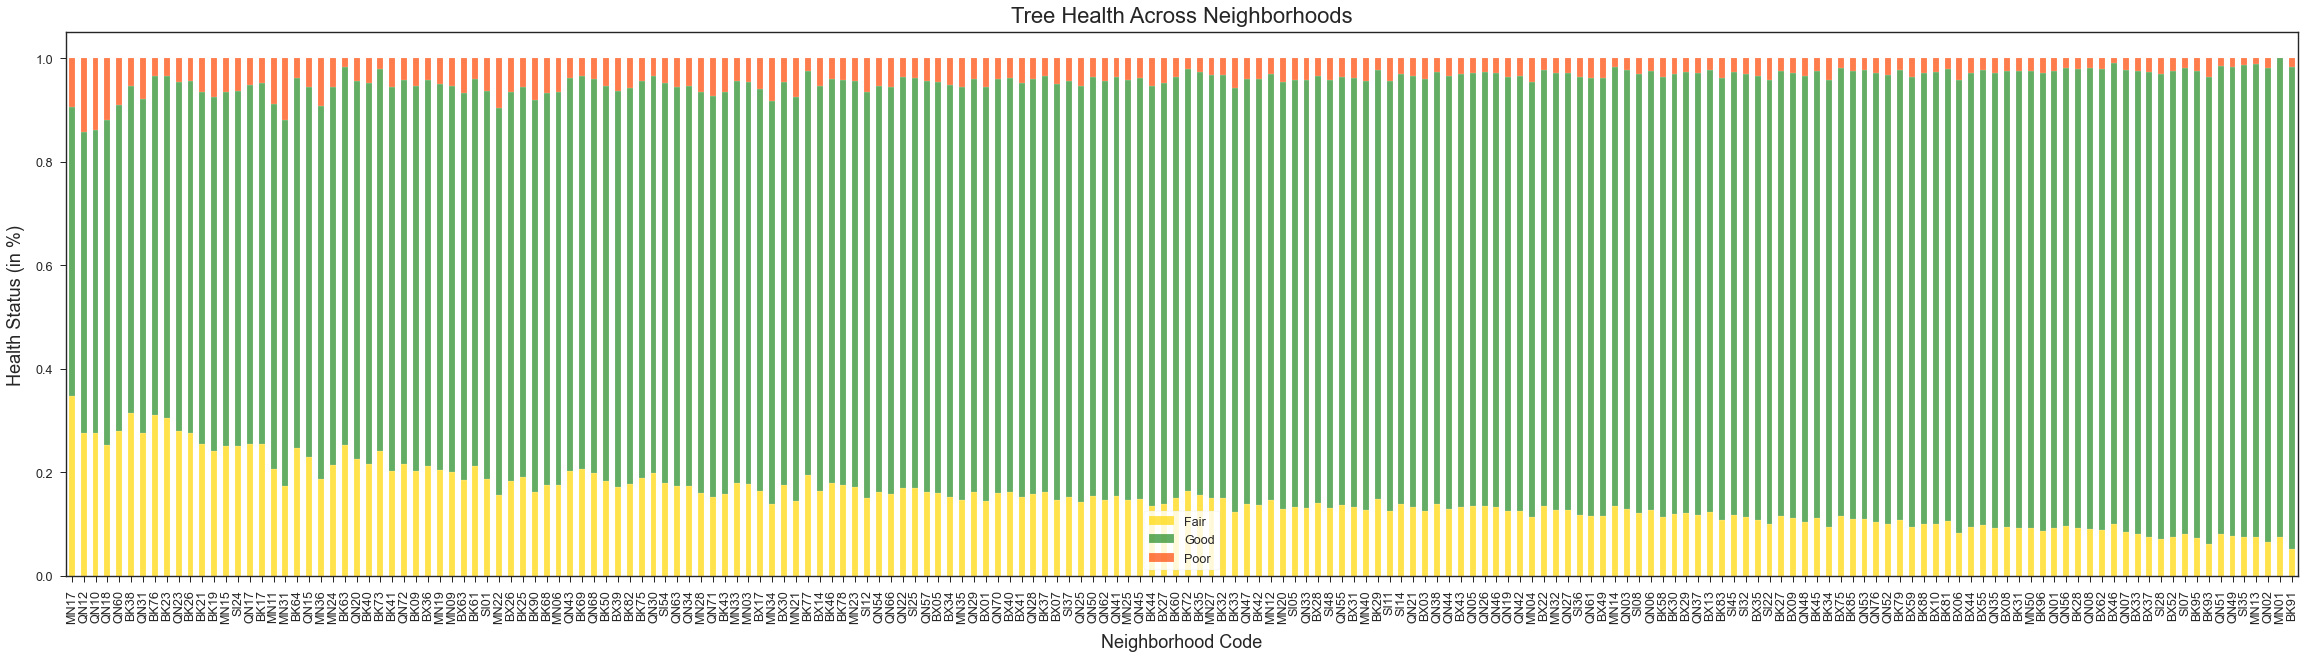

In [420]:
# sort by percentage of trees in good health
neighborhoods = trees.groupby(['nta']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p3 = neighborhoods.plot(kind = 'bar', stacked = True, figsize=(40,10),
#                    title = 'Tree Health Across Neighborhoods', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p3.set_title('Tree Health Across Neighborhoods', fontsize=22, pad=10)
p3.set_xlabel('Neighborhood Code', fontsize=18, labelpad=10)
p3.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p3.legend(['Fair','Good', 'Poor'])
plt.show()

* There does seem to be a difference between the neighborhoods, though these may be too correlated to community board, since each community board is composed of one or a few neighborhoods.
* Let's do some statistical analyses.

In [421]:
# create a frequency table
df_nta_health = pd.crosstab(trees.health, trees.nta)
df_nta_health

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,30,1132,182,314,136,675,215,151,187,296,...,959,668,214,1008,238,560,521,519,880,1782
Good,110,3082,514,839,295,2672,529,1116,1809,1655,...,2618,3134,2681,7563,2861,4035,2737,3764,5521,7685
Poor,8,215,57,81,15,197,35,32,41,45,...,241,150,92,271,40,175,148,119,275,482


In [422]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_nta_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(420.09408303637986, 12810.553650717877)

In [423]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table3 = sm.stats.Table(df_nta_health)
table3.standardized_resids

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,2.121165,21.797632,7.857331,11.350140,9.874106,8.323038,10.737758,-2.651511,-6.491918,0.824057,...,19.440027,4.914049,-11.037866,-7.587663,-10.644162,-4.870721,1.862093,-4.581456,-2.373582,10.766321
Good,-2.363995,-21.210308,-9.653901,-12.611392,-8.586783,-9.953336,-10.074908,3.831576,8.197327,1.274632,...,-21.315473,-4.119667,11.285759,9.153572,13.594823,4.992886,-2.217250,6.376933,1.881180,-11.963350
Poor,0.876589,2.936571,5.013913,4.615492,-0.681190,4.773887,0.710913,-2.822096,-4.577958,-3.978687,...,7.344349,-0.641763,-2.561007,-4.508978,-7.810264,-1.155269,1.049172,-4.396590,0.524073,4.379370


In [424]:
# percentage of significant values
abs_table3 = table3.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table3[abs_table3 > 1.96].count().sum() / abs_table3.count().sum()) * 100, 2)}%')

68.97%


* Percentage of significant values is lower than that of community boards. Might be an argument for using community boards as a feature instead.

### EDA - State Senate Districts

In [425]:
testers = ['boroname', 'cb_num', 'council_dist', 'nta', 'st_assem', 'st_senate']
for tester in testers:
    df_ = pd.crosstab(trees.health, trees[tester])
    table_ = sm.stats.Table(df_)
    abs_table_ = table_.standardized_resids.apply(lambda x: abs(x))
    print(f'{tester}: {round((abs_table_[abs_table_ > 1.96].count().sum() / abs_table_.count().sum()) * 100, 2)}%')

boroname: 73.33%
cb_num: 75.71%
council_dist: 77.78%
nta: 68.97%
st_assem: 77.95%
st_senate: 80.77%


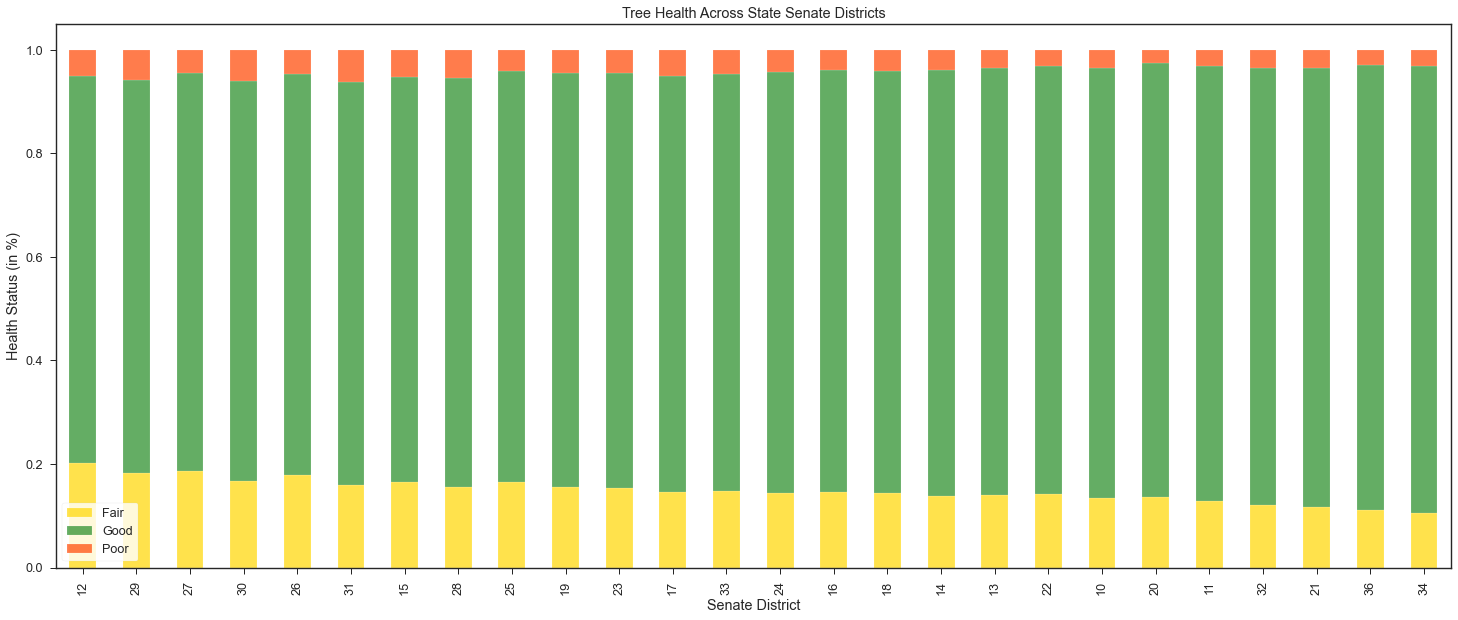

In [426]:
# sort by percentage of trees in good health
st_snt = trees.groupby(['st_senate']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p3 = st_snt.plot(kind = 'bar', stacked = True, figsize=(25,10),
                   title = 'Tree Health Across State Senate Districts', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p3.set_xlabel('Senate District')
p3.set_ylabel('Health Status (in %)')
p3.legend(['Fair','Good', 'Poor'])
plt.show()

In [427]:
# create a frequency table
df_snt = pd.crosstab(trees.health, trees.st_senate)
df_snt

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,3675,6815,1215,997,4219,4142,2299,1994,1122,3809,...,888,590,482,1358,831,745,1620,1507,2730,1322
Good,22605,44739,4506,5870,25245,19473,12746,10903,6379,19724,...,3857,2426,2433,5673,3821,3657,11258,8208,22610,10218
Poor,957,1610,301,246,1220,1323,610,693,320,1098,...,235,142,170,438,299,289,469,483,806,357


In [428]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table4 = sm.stats.Table(df_snt)
table4.standardized_resids

st_senate,10,11,12,13,14,15,16,17,18,19,...,26,27,28,29,30,31,32,33,34,36
health,,,,,,,,,,,,,,,,,,,,,
Fair,-3.392222,-9.639641,13.409767,-0.416550,-2.277409,11.281192,1.817599,1.645814,0.405191,5.908649,...,7.411160,7.265615,2.294573,9.977500,5.266404,3.342764,-6.891827,1.727133,-17.894877,-9.745348
Good,5.192473,14.875920,-14.164834,1.558396,2.147120,-15.729262,-1.320817,-4.880626,-0.591148,-7.285157,...,-8.037462,-7.306987,-4.266658,-13.251488,-8.515463,-6.891319,7.696308,-3.527251,20.128851,11.664743
Poor,-4.182700,-12.123317,4.005303,-2.327148,-0.171052,10.879156,-0.637121,6.680195,0.442341,3.820663,...,2.625243,1.445860,4.315015,8.321924,7.388149,7.616792,-2.878653,3.869758,-7.760328,-5.610385


In [429]:
# percentage of significant values
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()) * 100, 2)}%')

80.77%


* Percentage of significant values is higher than that of community boards. Might be an argument for using state senate districts as the best area marker of tree health.

### EDA - Tree species

In [430]:
print(f'Number of unique species: {len(trees.spc_common.unique())}')
print(f'Number of total trees: {len(trees)}')
print(f'Cutoff for trees of significant quantity (0.1% of total trees): {np.ceil(len(trees)/1000)}')

Number of unique species: 132
Number of total trees: 444390
Cutoff for trees of significant quantity (0.1% of total trees): 445.0


In [431]:
# create a column with the total count of that row's tree species
species_counts = trees['spc_common'].value_counts().rename('species_counts')

# merge onto dataframe
trees = trees.merge(species_counts.to_frame(),
                                left_on='spc_common',
                                right_index=True)

# reassign tree species with fewer than 445 datapoints to 'Other'
trees['spc_common'] = np.where(trees.species_counts < 445, 'Other', trees.spc_common)

trees.spc_common.value_counts().head(20)

London planetree     60350
Callery pear         42487
honeylocust          38349
pin oak              35985
Norway maple         25253
cherry               22772
Japanese zelkova     18928
littleleaf linden    18469
red maple            13906
ginkgo               11355
green ash            10572
Sophora              10440
silver maple         10081
Other                 9918
American linden       8399
sweetgum              8380
purple-leaf plum      5281
maple                 5211
American elm          5192
northern red oak      5153
Name: spc_common, dtype: int64

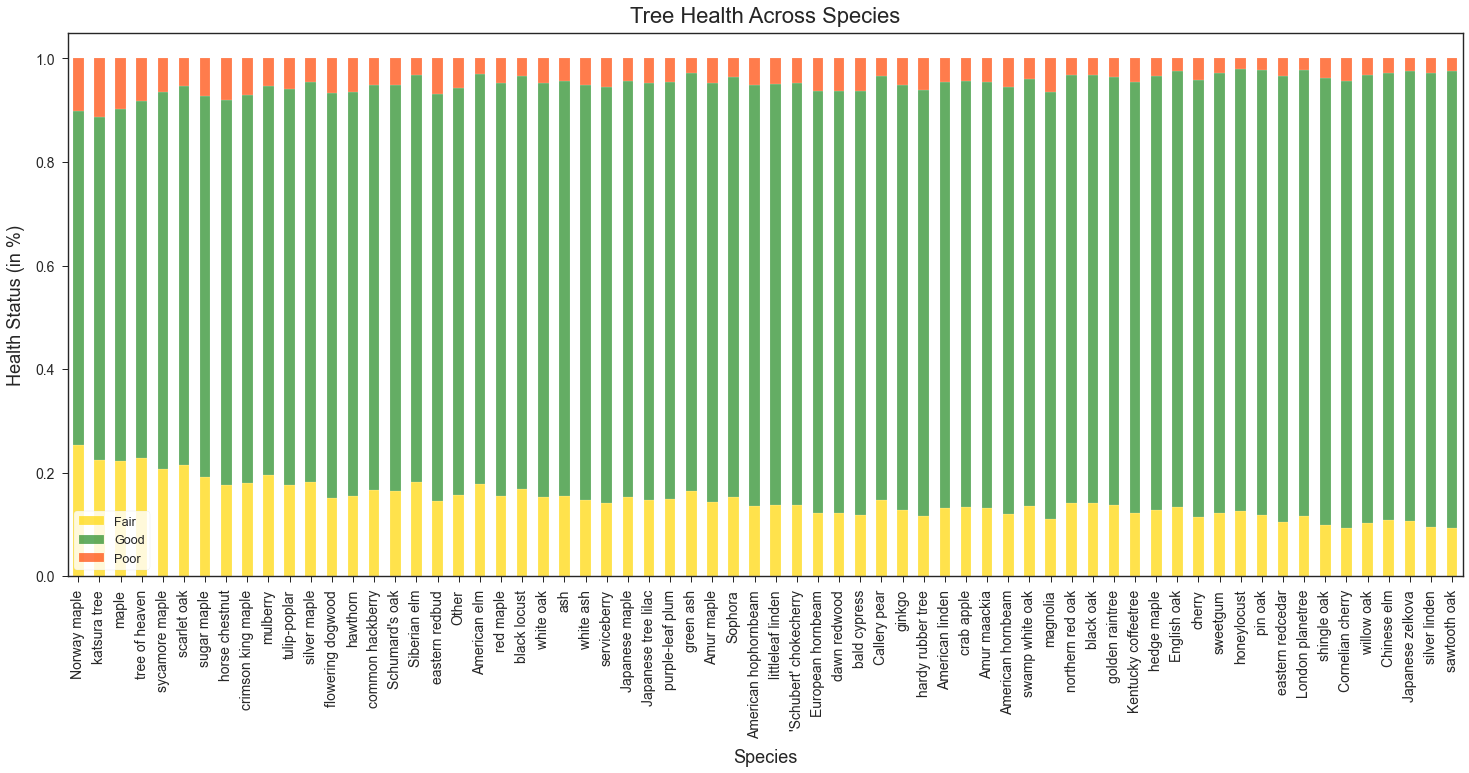

In [432]:
# sort by percentage of trees in good health
spc = trees.groupby(['spc_common']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p4 = spc.plot(kind = 'bar', stacked = True, figsize=(25,10),
#                    title = 'Tree Health Across Species', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, fontsize=14)
p4.set_title('Tree Health Across Species', fontsize=22, pad=10)
p4.set_xlabel('Species', fontsize=18, labelpad=10)
p4.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p4.legend(['Fair','Good', 'Poor'], loc='lower left')
plt.show()

* There does seem to be a difference between species.
* Let's do some statistical analyses.

In [433]:
# create a frequency table
df_spc_health = pd.crosstab(trees.health, trees.spc_common)
df_spc_health

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,442,926,93,140,1099,225,237,6216,304,65,...,1843,350,568,1017,405,106,129,130,175,210
Good,2606,4110,559,954,6913,1412,1342,34820,2444,608,...,7771,1345,3473,7125,1433,321,560,712,916,1761
Poor,151,156,35,63,387,77,79,1451,77,30,...,467,134,167,238,126,38,43,46,54,65


In [434]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_spc_health)

# test-statistic far greater than critical value
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(157.60992312288903, 10713.620636908676)

In [435]:
# create a table of standardized residuals; anything over +/-1.96 shows significance
table4 = sm.stats.Table(df_spc_health)
table4.standardized_resids

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,-0.603106,7.576995,-0.488967,-2.037439,-2.923916,-1.260565,0.124858,2.750728,-5.236162,-3.757917,...,11.917738,6.077938,-1.287867,-5.433738,8.189565,5.322743,2.666022,0.386499,1.064549,-5.020267
Good,-0.522527,-4.994458,-0.305859,0.562176,1.174069,0.604845,-0.927706,0.766975,6.490975,3.211830,...,-12.461487,-9.200599,1.208732,7.681683,-10.196686,-7.152113,-3.731584,-1.266663,-1.597022,5.481938
Poor,2.103740,-3.663597,1.473631,2.523008,2.897351,1.054760,1.604699,-6.411759,-3.454697,0.369866,...,3.308921,7.291597,-0.085981,-5.447825,5.491013,4.602577,2.599321,1.806109,1.248642,-1.852017


In [436]:
# percentage of significant values
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
print(f'{round((abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()) * 100, 2)}%')

62.12%


In [437]:
# drop no longer necessary counts column
trees.drop(columns='species_counts', axis=1, inplace=True)

In [438]:
# uncomment to save
# trees.to_csv('data/nyc_trees_2015_pre_dummies.csv')

### GeoPandas feature engineering

* Let's see if the distance between trees has any bearing on health. To do this, let's use all the datapoints.

In [440]:
trees_for_geo = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)
trees_for_geo.head()

,block_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,nta_name,latitude,longitude
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
200540,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
204026,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
204337,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
189565,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


In [441]:
# create geodataframe
trees_gdf = gpd.GeoDataFrame(trees_for_geo[['health', 'latitude', 'longitude']],
                             geometry=gpd.points_from_xy(trees_for_geo.longitude, trees_for_geo.latitude))
# reset index to sequential numbers
trees_gdf.reset_index(inplace=True)
trees_gdf.head()

,tree_id,health,latitude,longitude,geometry
0,180683,Fair,40.723092,-73.844215,POINT (-73.84422 40.72309)
1,200540,Fair,40.794111,-73.818679,POINT (-73.81868 40.79411)
2,204026,Good,40.717581,-73.936608,POINT (-73.93661 40.71758)
3,204337,Good,40.713537,-73.934456,POINT (-73.93446 40.71354)
4,189565,Good,40.666778,-73.975979,POINT (-73.97598 40.66678)


In [442]:
# Find closest tree and return a dataframe with a new distance column
closest_trees = nearest_neighbor(trees_gdf, return_dist=True)

closest_trees.head()

,tree_id,health,latitude,longitude,geometry,distance
0,236470,Good,40.723001,-73.844173,POINT (-73.84417 40.72300),5.507949
1,200541,Good,40.794090,-73.818770,POINT (-73.81877 40.79409),10.087328
2,204025,Good,40.717634,-73.936631,POINT (-73.93663 40.71763),3.098257
3,204336,Good,40.713563,-73.934360,POINT (-73.93436 40.71356),10.693152
4,218654,Good,40.666648,-73.975948,POINT (-73.97595 40.66665),5.258800


* See if distance from the nearest tree has any impact.

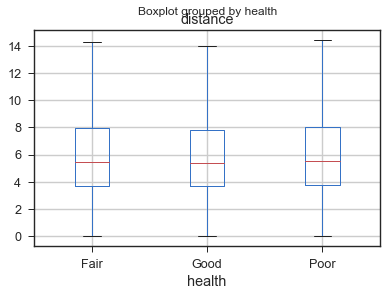

In [443]:
closest_trees.boxplot('distance', 'health', showfliers=False)

* Alas, the quartiles and medians are almost identical; there are no distinct differences here. Still, we'll prep this to add as a feature to our final model to see if it holds any predictive power there.

In [445]:
closest_trees.set_index('tree_id', inplace = True)

### Dummy columns

* We have a lot of categorical variables that we need to make dummies for.
* We also have to decide which area variable to use: community board? council district? state assembly? state senate? neighborhood?

In [459]:
trees = pd.read_csv('data/nyc_trees_2015_pre_dummies.csv', index_col=0)

In [460]:
trees = pd.merge(trees, closest_trees['distance'], left_index=True, right_index=True)
# normalize the values
rein_extremes(trees, ['distance'])

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,...,branch_shoe,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,log_block_count,distance
tree_id,,,,,,,,,,,,,,,,,,,,,
4,20.0,OnCurb,Good,pin oak,1or2,None,NoDamage,No,No,No,...,No,No,202,Bronx,17,84,32,BX27,2.564949,10.171003
4,20.0,OnCurb,Good,pin oak,1or2,None,NoDamage,No,No,No,...,No,No,202,Bronx,17,84,32,BX27,2.564949,6.652240
8,3.0,OnCurb,Poor,Other,3or4,None,NoDamage,No,No,No,...,No,No,202,Bronx,17,84,34,BX27,2.302585,5.916236
8,3.0,OnCurb,Poor,Other,3or4,None,NoDamage,No,No,No,...,No,No,202,Bronx,17,84,34,BX27,2.302585,2.705767
9,4.0,OnCurb,Poor,Other,3or4,None,NoDamage,No,No,No,...,No,No,202,Bronx,17,84,34,BX27,2.302585,2.521101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722689,5.0,OnCurb,Good,pin oak,None,None,NoDamage,No,No,No,...,No,No,301,Brooklyn,34,53,18,BK90,1.609438,4.047974
722691,2.0,OnCurb,Good,red maple,None,None,NoDamage,No,No,No,...,No,No,318,Brooklyn,46,58,19,BK50,1.609438,14.813365
722693,3.0,OnCurb,Good,littleleaf linden,None,None,NoDamage,No,No,No,...,No,No,318,Brooklyn,46,58,19,BK50,1.609438,8.510339


In [461]:
trees.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'log_block_count', 'distance'],
      dtype='object')

In [462]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [463]:
trees.sidewalk.unique()

array(['NoDamage', 'Damage'], dtype=object)

In [464]:
# rename columns that we have to manually dummy, so the new 0 and 1 values make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage'}, inplace=True)

# trees on curb = 1; trees offset from curb = 0
trees.on_curb = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree = 1; no sidewalk damage = 0
trees.sidewalk_damage = np.where(trees.sidewalk_damage == 'Damage', 1, 0)

* Reassign yes-no columns to 1s and 0s.

In [465]:
trees.branch_other.unique()

array(['No', 'Yes'], dtype=object)

In [466]:
# create list of columns to dummy
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']

# call custom function
yes_to_one(trees, yes_no_cols)
# check to make sure it worked
trees.branch_other.unique()

array([0, 1])

In [467]:
yes_no_cols.extend(['on_curb', 'sidewalk_damage'])

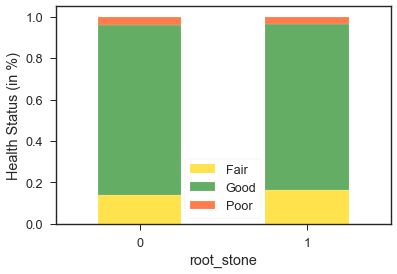

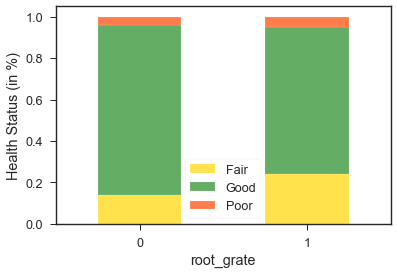

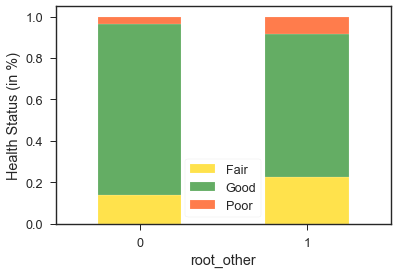

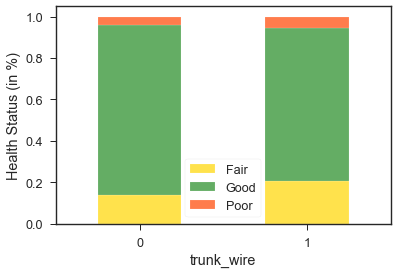

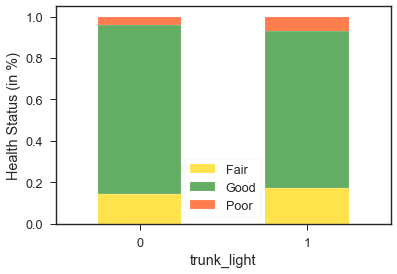

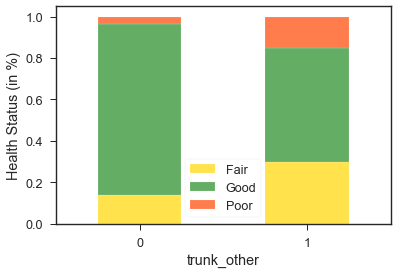

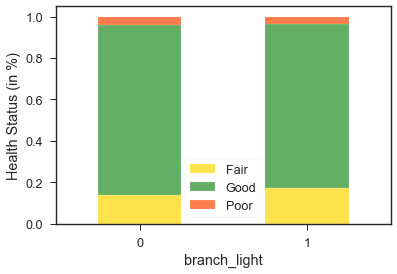

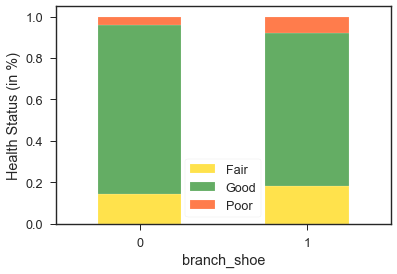

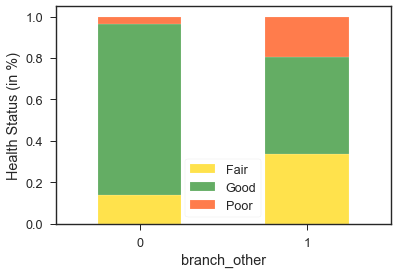

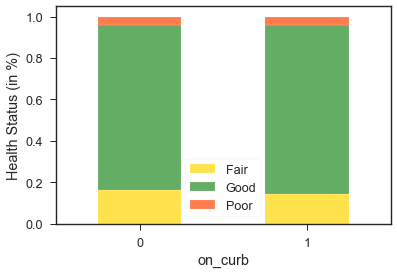

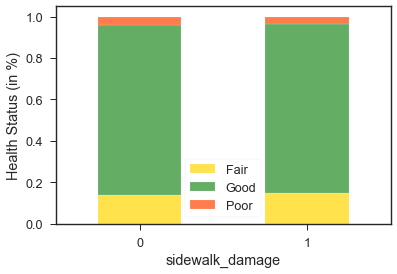

In [468]:
# for loop of what we were doing before, so we can take a look at all these binary variables
for col in yes_no_cols:
    grouped = trees.groupby(col).health.value_counts(normalize=True).unstack()
    ax = grouped.plot(kind = 'bar', stacked = True, 
#                        title = f'', 
                       color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
    ax.set_xticklabels([0,1], rotation=0)
    ax.set_xlabel(col)
    ax.set_ylabel('Health Status (in %)')
    ax.legend(['Fair','Good', 'Poor'])

* Lots of signficant looking variables here. Some that don't quite meet the mark are: root_stone, branch_light, on_curb, and sidewalk_damage.

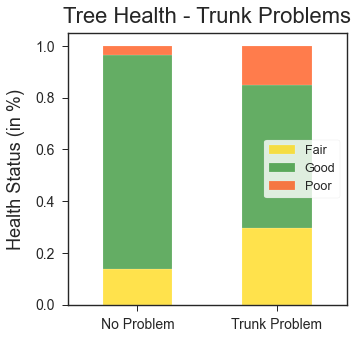

In [477]:
# sort by percentage of trees in good health
trunk_o = trees.groupby(['trunk_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot a stacked bar graph
p5 = trunk_o.plot(kind = 'bar', stacked = True, figsize=(5,5),
#                    title = 'Tree Health Across Species', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, fontsize=14)
p5.set_title('Tree Health - Trunk Problems', fontsize=22, pad=10)
p5.set_xlabel('')
p5.set_xticklabels(['No Problem', 'Trunk Problem'], rotation='horizontal')
p5.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p5.legend(['Fair','Good', 'Poor'], loc=5)
plt.show()

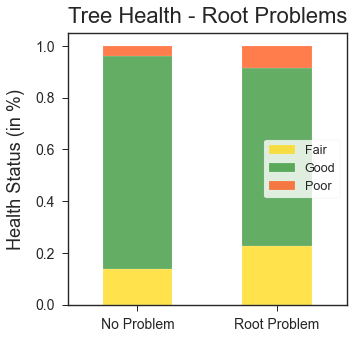

In [481]:
# sort by percentage of trees in good health
root_o = trees.groupby(['root_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot a stacked bar graph
p6 = root_o.plot(kind = 'bar', stacked = True, figsize=(5,5),
#                    title = 'Tree Health Across Species', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, fontsize=14)
p6.set_title('Tree Health - Root Problems', fontsize=22, pad=10)
p6.set_xlabel('')
p6.set_xticklabels(['No Problem', 'Root Problem'], rotation='horizontal')
p6.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p6.legend(['Fair','Good', 'Poor'], loc=5)
plt.show()

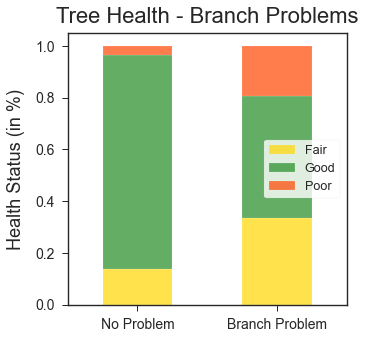

In [479]:
# sort by percentage of trees in good health
branch_o = trees.groupby(['branch_other']).health.value_counts(normalize=True).unstack().sort_values('Good', ascending=False)

# plot a stacked bar graph
p7 = branch_o.plot(kind = 'bar', stacked = True, figsize=(5,5),
#                    title = 'Tree Health Across Species', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70, fontsize=14)
p7.set_title('Tree Health - Branch Problems', fontsize=22, pad=10)
p7.set_xlabel('')
p7.set_xticklabels(['No Problem', 'Branch Problem'], rotation='horizontal')
p7.set_ylabel('Health Status (in %)', fontsize=18, labelpad=10)
p7.legend(['Fair','Good', 'Poor'], loc=5)
plt.show()

* Dummy variables with more than two values:
    * First rename a steward value that doesn't make sense (4 is accounted for twice, so renaming '4orMore' to '5plus').
    * Create dummies for number of stewards, usefulness of tree guards, and borough name.

In [482]:
trees['steward'] = np.where(trees.steward == '4orMore', '5plus', trees.steward)

In [483]:
trees.steward.unique()

array(['1or2', '3or4', 'None', '5plus'], dtype=object)

In [484]:
trees.groupby('steward').health.value_counts(normalize=True)

steward  health
1or2     Good      0.811677
         Fair      0.147157
         Poor      0.041166
3or4     Good      0.826952
         Fair      0.132680
         Poor      0.040368
5plus    Good      0.834770
         Fair      0.129310
         Poor      0.035920
None     Good      0.820114
         Fair      0.140653
         Poor      0.039233
Name: health, dtype: float64

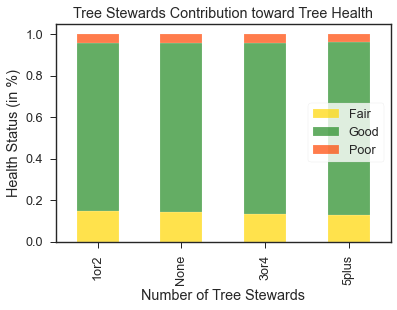

In [488]:
# sort by percentage of trees in good health
stewards = trees.groupby(['steward']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p8 = stewards.plot(kind = 'bar', stacked = True, 
                   title = 'Tree Stewards Contribution toward Tree Health', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p8.set_xlabel('Number of Tree Stewards')
p8.set_ylabel('Health Status (in %)')
p8.legend(['Fair','Good', 'Poor'])
plt.show()

* Health status looks similar across all values.

In [486]:
trees.guards.value_counts()

None       413265
Helpful     21818
Harmful      6297
Unsure       3308
Name: guards, dtype: int64

In [487]:
trees.groupby('guards').health.value_counts(normalize=True)

guards   health
Harmful  Good      0.769255
         Fair      0.181039
         Poor      0.049706
Helpful  Good      0.830507
         Fair      0.129847
         Poor      0.039646
None     Good      0.819273
         Fair      0.141418
         Poor      0.039309
Unsure   Good      0.769649
         Fair      0.175635
         Poor      0.054716
Name: health, dtype: float64

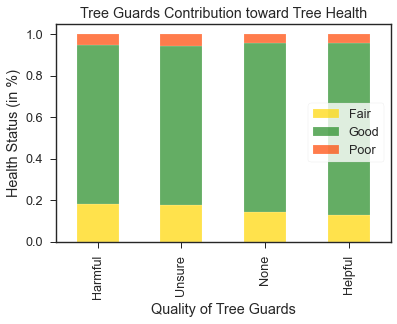

In [489]:
# sort by percentage of trees in good health
guards = trees.groupby(['guards']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot a stacked bar graph
p9 = guards.plot(kind = 'bar', stacked = True, 
                   title = 'Tree Guards Contribution toward Tree Health', 
                   color = ['gold', 'forestgreen', 'orangered'], alpha = .70)
p9.set_xlabel('Quality of Tree Guards')
p9.set_ylabel('Health Status (in %)')
p9.legend(['Fair','Good', 'Poor'])
plt.show()

* Health status looks affected by the quality of the tree guards.

## Vanilla model interruption
* Now is a good opportunity to look at a starting point for our model. Let's take a look at a random forest.

In [491]:
prelim_features = ['tree_dbh', 'on_curb', 'sidewalk_damage', 'root_stone', 'root_grate', 'root_other',
                   'trunk_wire', 'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe', 'branch_other']

In [492]:
X_van = trees[prelim_features]
y_van = trees['health']

In [493]:
X_train_van, X_test_van, y_train_van, y_test_van = train_test_split(X_van, y_van, random_state=42, stratify=y_van)

# use a scaler so we can get the continuous variable on the same scale
scaler = StandardScaler()  
scaler.fit(X_train_van)

X_train = scaler.transform(X_train_van)  
X_test = scaler.transform(X_test_van)

In [494]:
# vanilla random forest
van_forest = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)

# fit training data
van_forest.fit(X_train_van, y_train_van)

# predict test dta
van_pred_forest = van_forest.predict(X_test_van)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, van_pred_forest))
# check f1
print('Test F1 score: ', f1_score(y_test_van, van_pred_forest, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test_van, van_pred_forest, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test_van, van_pred_forest, average='weighted'))

Test Accuracy score:  0.5439409203756341
Test F1 score:  0.6133921972565646
Test Recall score:  0.5439409203756341
Test Precision score:  0.7265665490035008


* Not great, but let's take a look at a confusion matrix.

Normalized confusion matrix
[[0.19410756 0.50428599 0.30160645]
 [0.12972688 0.60938015 0.26089297]
 [0.14087707 0.41672347 0.44239945]]


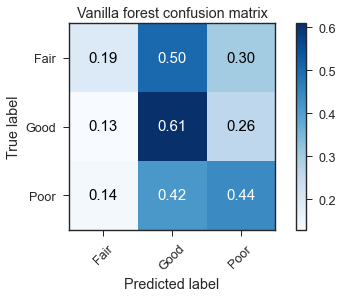

In [664]:
cm_van = confusion_matrix(y_test_van, van_pred_forest)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_van, classes,
                          normalize=True,
                          title='Vanilla forest confusion matrix',
                          cmap=plt.cm.Blues)

* Let's take a look at which features proved important.

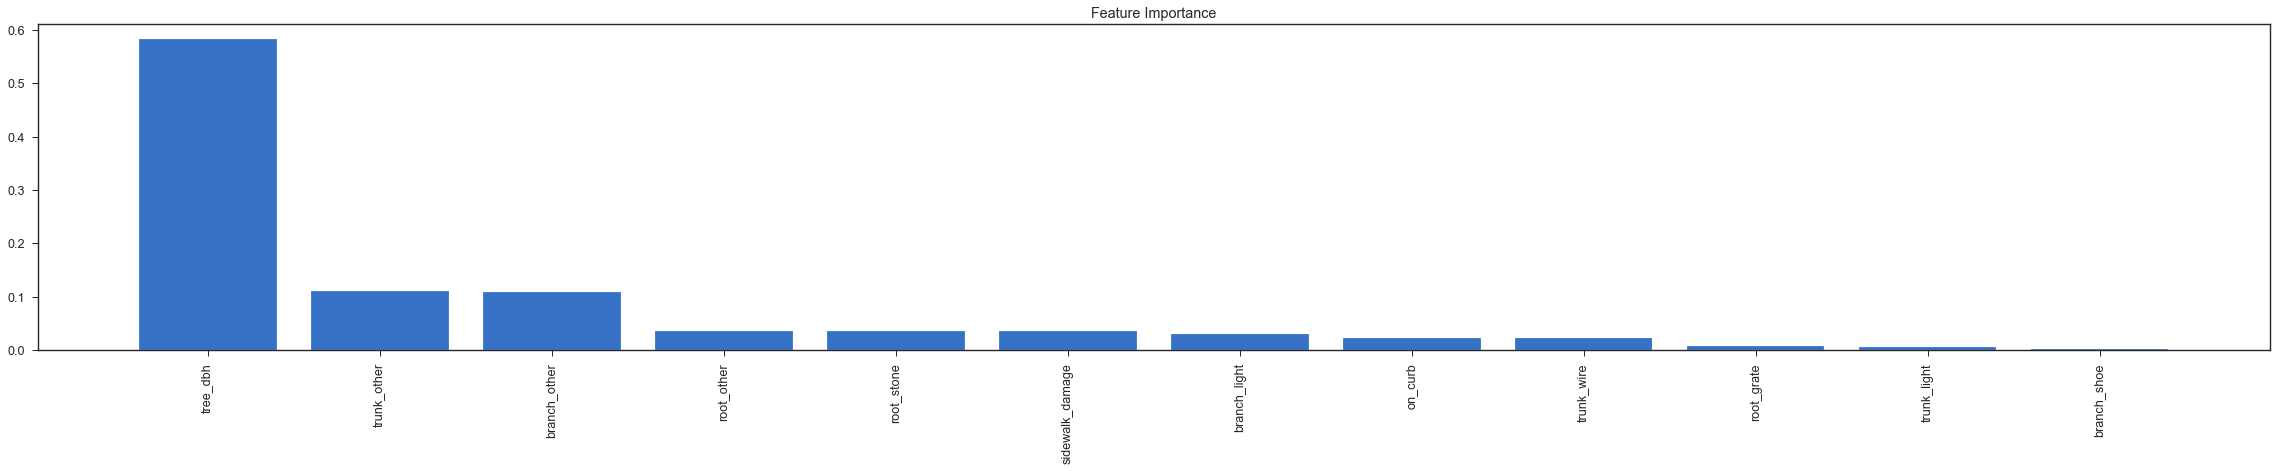

[('tree_dbh', 0.582544413365287), ('trunk_other', 0.1095695141955782), ('branch_other', 0.10917222890327155), ('root_other', 0.03626799202853932), ('root_stone', 0.035280271367538314), ('sidewalk_damage', 0.03495135865789347), ('branch_light', 0.029392910847745157), ('on_curb', 0.02325312222715326), ('trunk_wire', 0.022592836979274035), ('root_grate', 0.00815908079130375), ('trunk_light', 0.006286175940042501), ('branch_shoe', 0.002530094696373277)]


In [496]:
plot_forest_features(van_forest, X_train_van)

* Some surprises here: tree diameter topped the list by a large margin. Many of our categorical variables hold equal importance.
* We'll keep those in for now and see how they perform in our final model.

### Finishing up our dummies
* After some research, I'm going to go with the local level community board as my variable for "region" of the city.
    * One has to interact with the community board and get permits in order to affect any change on NYC street trees, so that makes the most sense narratively.

In [497]:
dummy_cols = ['steward', 'guards', 'boroname', 'cb_num', 'spc_common']

# convert community board column to string so we can easily dummy it
trees['cb_num'] = trees.cb_num.astype(str)

In [498]:
tree_dummies = pd.get_dummies(trees[dummy_cols])
tree_dummies.columns = [col.replace(' ', '_').replace("'", "") for col in list(tree_dummies.columns)]
tree_dummies.columns

Index(['steward_1or2', 'steward_3or4', 'steward_5plus', 'steward_None',
       'guards_Harmful', 'guards_Helpful', 'guards_None', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn',
       ...
       'spc_common_silver_maple', 'spc_common_sugar_maple',
       'spc_common_swamp_white_oak', 'spc_common_sweetgum',
       'spc_common_sycamore_maple', 'spc_common_tree_of_heaven',
       'spc_common_tulip-poplar', 'spc_common_white_ash',
       'spc_common_white_oak', 'spc_common_willow_oak'],
      dtype='object', length=138)

In [499]:
# add onto our dummy_cols list, so we can drop our pre-dummied columns, plus a dummy from each,
# plus the columns we no longer need
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten_Island', 'cb_num_101', 'spc_common_Other',
                  'council_dist', 'st_assem', 'st_senate', 'nta'])

In [500]:
trees_full = pd.concat([trees,tree_dummies], axis=1)
trees_full.drop(columns=dummy_cols, axis=1, inplace=True)

In [501]:
trees_full.columns

Index(['tree_dbh', 'on_curb', 'health', 'sidewalk_damage', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       ...
       'spc_common_silver_maple', 'spc_common_sugar_maple',
       'spc_common_swamp_white_oak', 'spc_common_sweetgum',
       'spc_common_sycamore_maple', 'spc_common_tree_of_heaven',
       'spc_common_tulip-poplar', 'spc_common_white_ash',
       'spc_common_white_oak', 'spc_common_willow_oak'],
      dtype='object', length=148)

In [502]:
trees_full.head()

,tree_dbh,on_curb,health,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,...,spc_common_silver_maple,spc_common_sugar_maple,spc_common_swamp_white_oak,spc_common_sweetgum,spc_common_sycamore_maple,spc_common_tree_of_heaven,spc_common_tulip-poplar,spc_common_white_ash,spc_common_white_oak,spc_common_willow_oak
tree_id,,,,,,,,,,,,,,,,,,,,,
4,20.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1,Poor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1,Poor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4.0,1,Poor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [503]:
trees_full.to_csv('data/nyc_trees_final.csv')

In [504]:
trees_full = pd.read_csv('data/nyc_trees_final.csv', index_col=0)
trees_full.head()

,tree_dbh,on_curb,health,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,...,spc_common_silver_maple,spc_common_sugar_maple,spc_common_swamp_white_oak,spc_common_sweetgum,spc_common_sycamore_maple,spc_common_tree_of_heaven,spc_common_tulip-poplar,spc_common_white_ash,spc_common_white_oak,spc_common_willow_oak
tree_id,,,,,,,,,,,,,,,,,,,,,
4,20.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1,Poor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1,Poor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4.0,1,Poor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-test split and modeling

In [508]:
# create our features and target
X = trees_full.drop(columns=['health'], axis=1)
y = trees_full['health']

In [509]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# use a scaler so we can get the two continuous variables on the same scale
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

### Basic random forest

In [510]:
# basic random forest
forest = RandomForestClassifier(class_weight='balanced', random_state=99, n_jobs=-1)

# fit training data
forest.fit(X_train, y_train)

# predict test dta
y_pred_forest = forest.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest, average='weighted'))

Test Accuracy score:  0.8448440254740402
Test F1 score:  0.8143650635924813
Test Recall score:  0.8448440254740402
Test Precision score:  0.8202075380280115


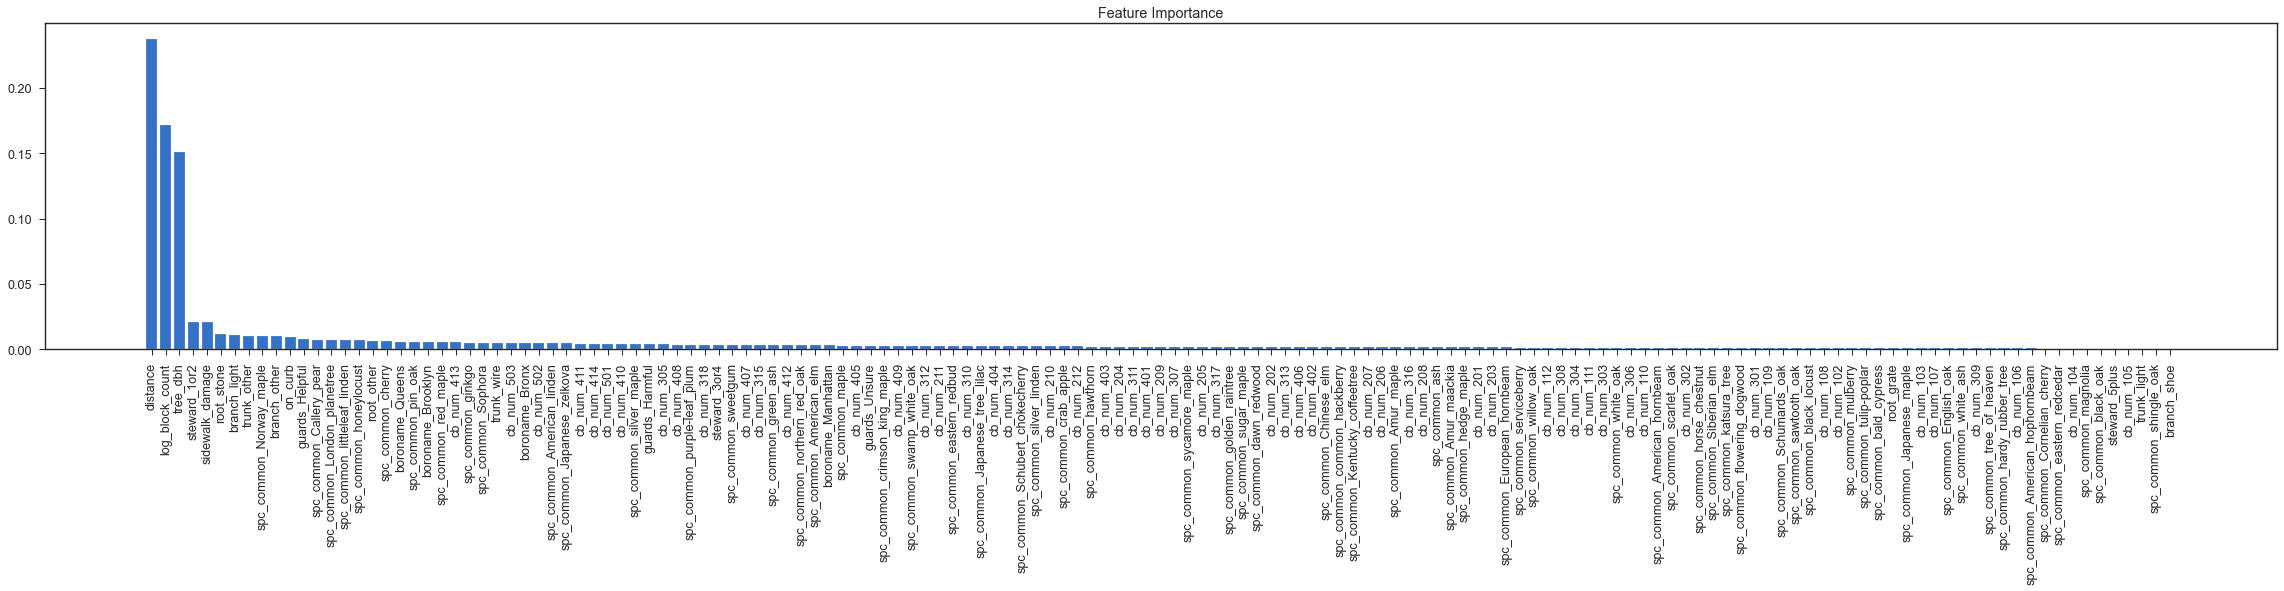

[('distance', 0.23755635857328353), ('log_block_count', 0.17165480692235252), ('tree_dbh', 0.15064900466810704), ('steward_1or2', 0.020716336823364902), ('sidewalk_damage', 0.020677226714261407), ('root_stone', 0.012070192770390321), ('branch_light', 0.010880412463368619), ('trunk_other', 0.010552804000352786), ('spc_common_Norway_maple', 0.010380380865761112), ('branch_other', 0.010129608871975206), ('on_curb', 0.0093302908875645), ('guards_Helpful', 0.008141848736365288), ('spc_common_Callery_pear', 0.007421618682011931), ('spc_common_London_planetree', 0.007261289174601303), ('spc_common_littleleaf_linden', 0.00702978613710309), ('spc_common_honeylocust', 0.0068634660751174656), ('root_other', 0.00648345135952643), ('spc_common_cherry', 0.0063258094265338785), ('boroname_Queens', 0.006018536012987305), ('spc_common_pin_oak', 0.005958790032721526), ('boroname_Brooklyn', 0.0059058874688417366), ('spc_common_red_maple', 0.005858899578334787), ('cb_num_413', 0.005822072727989394), ('spc

In [511]:
# find feature importance; input model name 
plot_forest_features(forest, X)

Normalized confusion matrix
[[0.25963553 0.72214109 0.01822338]
 [0.02052251 0.9762475  0.00322999]
 [0.09952284 0.67916383 0.22131334]]


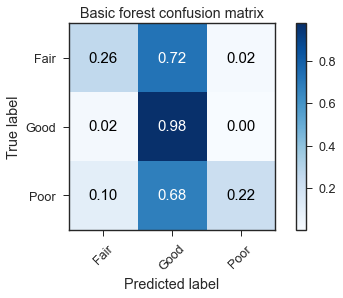

In [665]:
cm = confusion_matrix(y_test, y_pred_forest)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Basic forest confusion matrix',
                          cmap=plt.cm.Blues)

### Smote

In [513]:
smoten = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smoten.fit_sample(X_train, y_train)

In [514]:
# random forest
forest_smote = RandomForestClassifier(
#                                         class_weight='balanced',
                                        random_state=99, n_jobs=-1)

# fit training data
forest_smote.fit(X_train_smote, y_train_smote)

# predict test dta
y_pred_forest_smote = forest_smote.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_smote))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_smote, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_smote, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_smote, average='weighted'))

Test Accuracy score:  0.8381247076602022
Test F1 score:  0.8152856189368165
Test Recall score:  0.8381247076602022
Test Precision score:  0.8178993143316626


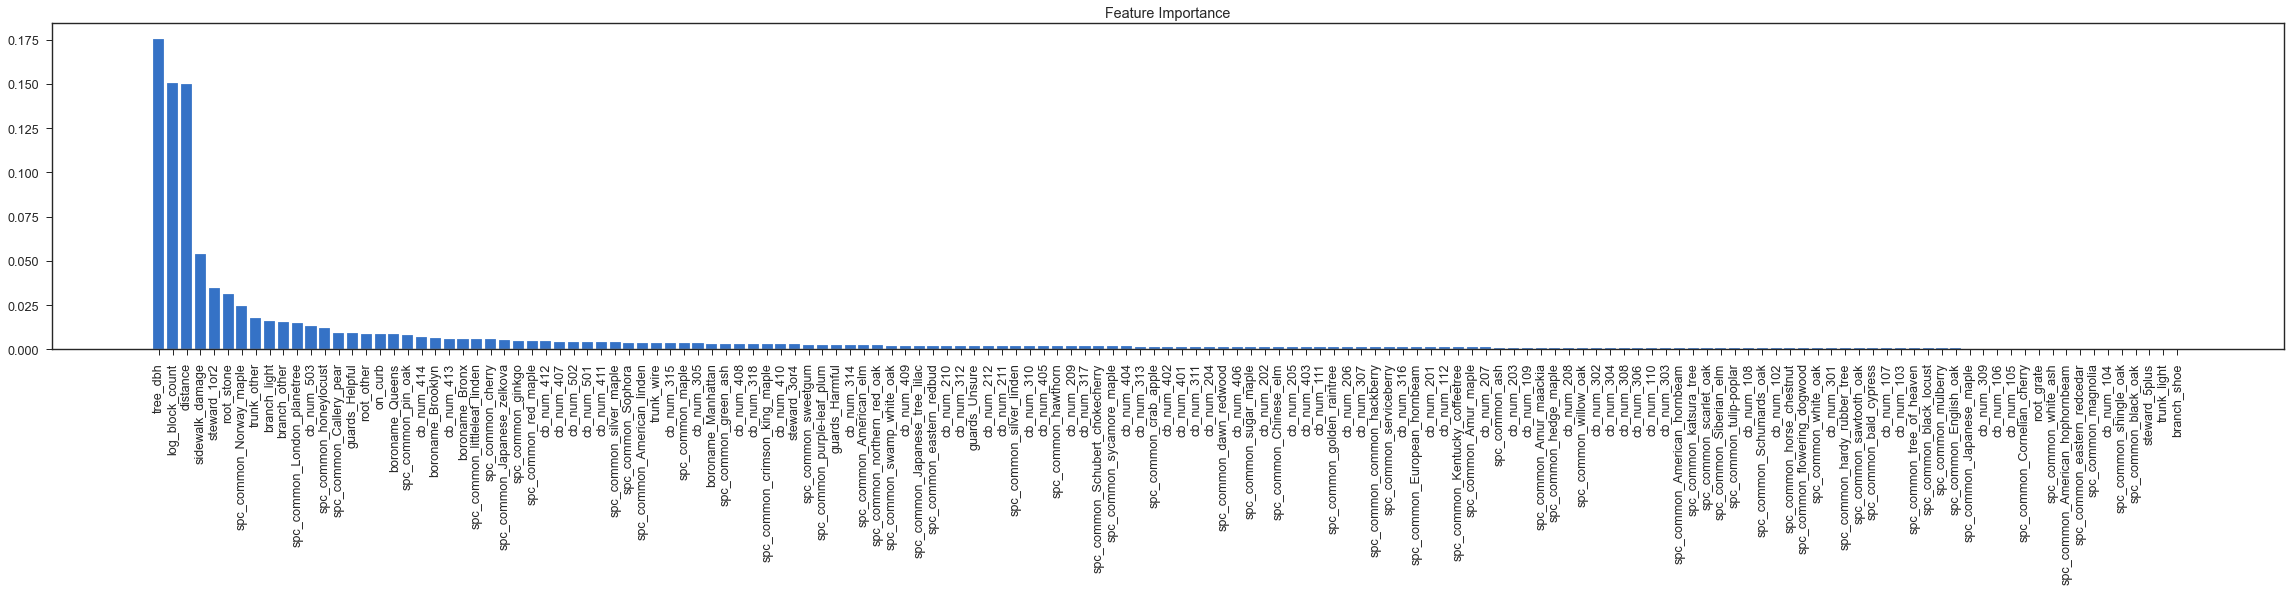

[('tree_dbh', 0.17547691043011657), ('log_block_count', 0.1503878843753296), ('distance', 0.1499508915745741), ('sidewalk_damage', 0.05370636507199392), ('steward_1or2', 0.03474405408344845), ('root_stone', 0.03130007297124102), ('spc_common_Norway_maple', 0.024328723245378815), ('trunk_other', 0.017973209763564525), ('branch_light', 0.016171312355664224), ('branch_other', 0.01558992082574213), ('spc_common_London_planetree', 0.014914572696909436), ('cb_num_503', 0.01306514802442871), ('spc_common_honeylocust', 0.011980064453180467), ('spc_common_Callery_pear', 0.00955801552392211), ('guards_Helpful', 0.009013707915031477), ('root_other', 0.008910240897959887), ('on_curb', 0.008789132099793493), ('boroname_Queens', 0.008643608586613151), ('spc_common_pin_oak', 0.008159530967639602), ('cb_num_414', 0.007002333594031229), ('boroname_Brooklyn', 0.006233292050878853), ('cb_num_413', 0.006171472938346281), ('boroname_Bronx', 0.006079791381972947), ('spc_common_littleleaf_linden', 0.00595587

In [515]:
plot_forest_features(forest_smote, X)

Normalized confusion matrix
[[0.26935043 0.67667788 0.05397168]
 [0.02170904 0.96018545 0.01810551]
 [0.08566235 0.56532606 0.34901159]]


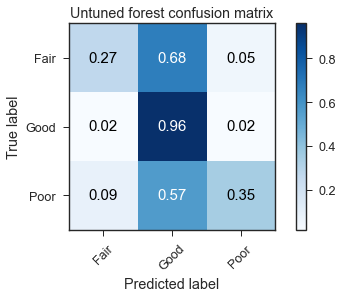

In [666]:
cm_smote = confusion_matrix(y_test, y_pred_forest_smote)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_smote, classes,
                          normalize=True,
                          title='Untuned forest confusion matrix',
                          cmap=plt.cm.Blues)

In [572]:
# random forest
forest_smote_tuned = RandomForestClassifier(max_features=11,
                                       min_samples_leaf=3,
                                        class_weight='balanced',
                                        random_state=99, n_jobs=-1,
                                      n_estimators=1000
                                      )

# fit training data
forest_smote_tuned.fit(X_train_smote, y_train_smote)

# predict test dta
y_pred_forest_smote_tuned = forest_smote_tuned.predict(X_test)

# check accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_forest_smote_tuned))
# check f1
print('Test F1 score: ', f1_score(y_test, y_pred_forest_smote_tuned, average='weighted'))
# check recall
print('Test Recall score: ', recall_score(y_test, y_pred_forest_smote_tuned, average='weighted'))
# check precision
print('Test Precision score: ', precision_score(y_test, y_pred_forest_smote_tuned, average='weighted'))

Test Accuracy score:  0.7616396214874249
Test F1 score:  0.7736425418889094
Test Recall score:  0.7616396214874249
Test Precision score:  0.7884220075903725


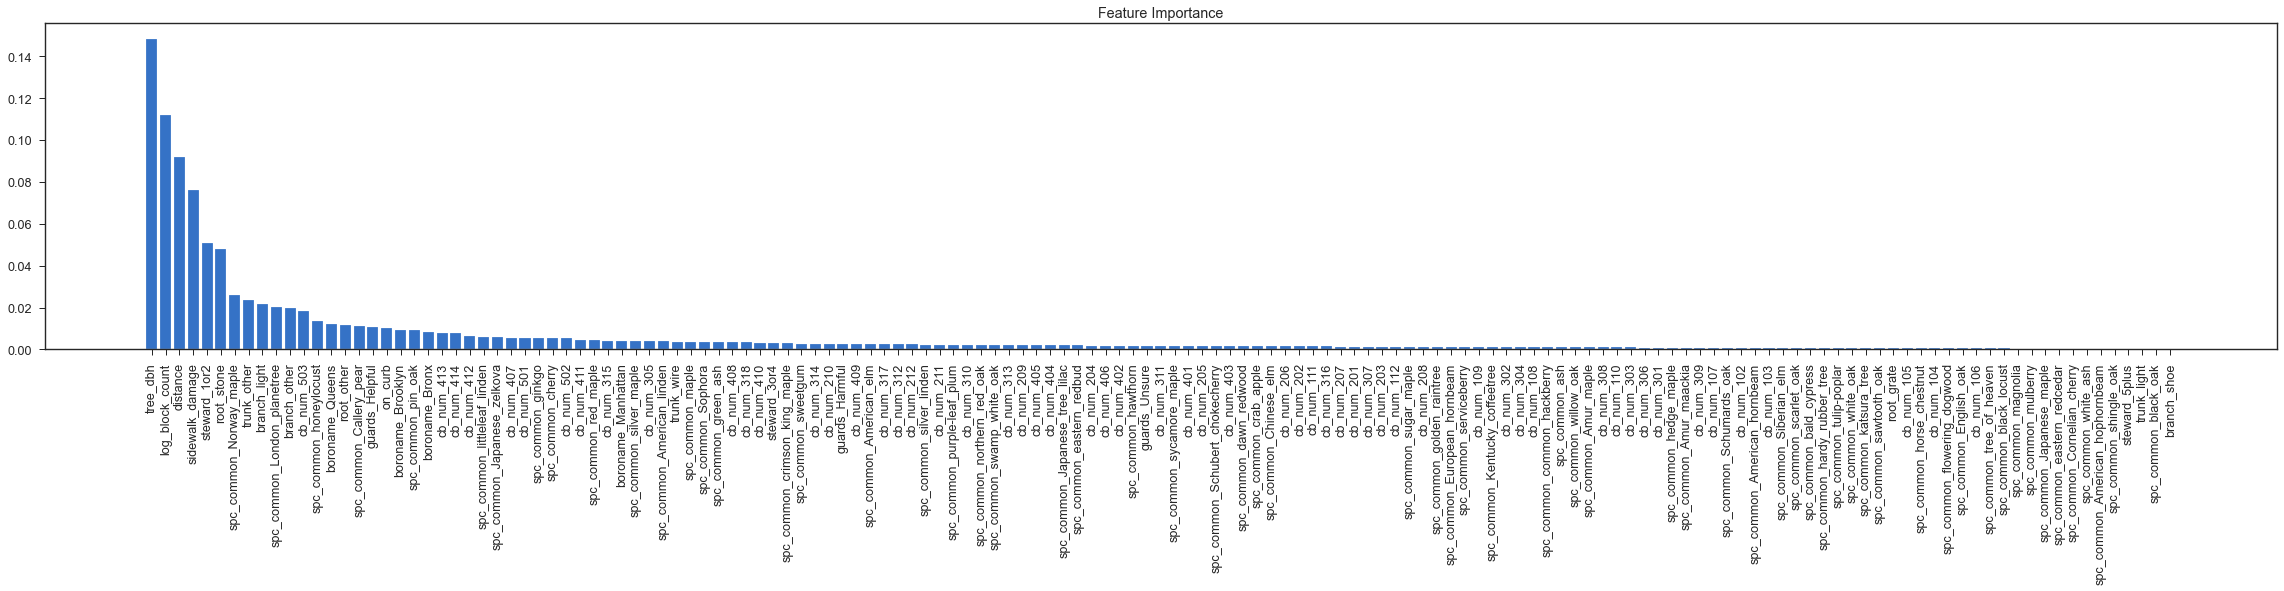

[('tree_dbh', 0.148314638940995), ('log_block_count', 0.11201324688044793), ('distance', 0.09168603513427673), ('sidewalk_damage', 0.07620097609008976), ('steward_1or2', 0.05092576588293177), ('root_stone', 0.04796636840148296), ('spc_common_Norway_maple', 0.02580909315236273), ('trunk_other', 0.02370460739543172), ('branch_light', 0.021873949873060388), ('spc_common_London_planetree', 0.020243214312125096), ('branch_other', 0.019721012339417955), ('cb_num_503', 0.01818259575394225), ('spc_common_honeylocust', 0.013408595834688059), ('boroname_Queens', 0.012210717580605721), ('root_other', 0.011696964743013698), ('spc_common_Callery_pear', 0.01117168422304421), ('guards_Helpful', 0.010899611741161571), ('on_curb', 0.010396503527983785), ('boroname_Brooklyn', 0.00913140790268821), ('spc_common_pin_oak', 0.009091641199156973), ('boroname_Bronx', 0.008479944038175332), ('cb_num_413', 0.008076069312020082), ('cb_num_414', 0.008058808168592313), ('cb_num_412', 0.006406799943663449), ('spc_c

In [573]:
plot_forest_features(forest_smote_tuned, X)

Normalized confusion matrix
[[0.43685313 0.4812369  0.08190996]
 [0.11993804 0.84046714 0.03959482]
 [0.28993411 0.41649625 0.29356964]]


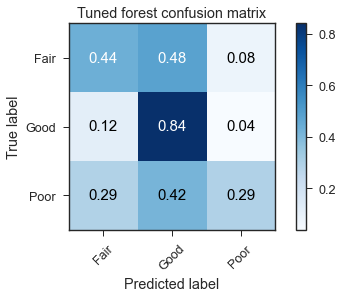

In [663]:
cm_smote_tuned = confusion_matrix(y_test, y_pred_forest_smote4)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_smote_tuned, classes,
                          normalize=True,
                          title='Tuned forest confusion matrix',
                          cmap=plt.cm.Blues)

In [670]:
with open('data/final_model.pickle', 'wb') as f:
    pickle.dump(forest_smote_tuned, f, protocol=pickle.HIGHEST_PROTOCOL)

In [625]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes object with prior probabilities of each class
gnb = GaussianNB(priors=[0.14, 0.82, 0.04],
#                  var_smoothing=.25
                )

# Train model
ganaba = gnb.fit(X_train_smote, y_train_smote)

In [626]:
#Predict the response for test dataset
y_pred_gnb = ganaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_gnb))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_gnb, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_gnb, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_gnb, average='weighted'))

Test Accuracy score:  0.632227539308459
Test F1 score:  0.6745518169191478
Test Recall score:  0.632227539308459
Test Precision score:  0.7324375601649583


Normalized confusion matrix
[[0.20287002 0.57381421 0.22331577]
 [0.12179473 0.72114434 0.15706093]
 [0.17905022 0.49125199 0.3296978 ]]


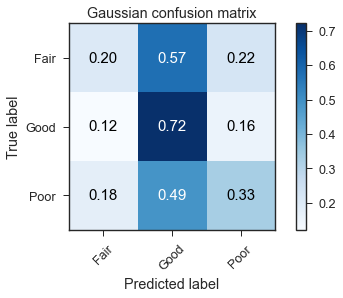

In [667]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_gnb, classes,
                          normalize=True,
                          title='Gaussian confusion matrix',
                          cmap=plt.cm.Blues)

In [610]:
from sklearn.naive_bayes import BernoulliNB

# Create Bernoulli Naive Bayes object with prior probabilities of each class
bnb = BernoulliNB(class_prior=[0.175, 0.75, 0.075])

# Train model
banaba = bnb.fit(X_train_smote, y_train_smote)

In [611]:
#Predict the response for test dataset
y_pred_bnb = banaba.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb, average='weighted'))

Test Accuracy score:  0.8138560069082142
Test F1 score:  0.7486348313408798
Test Recall score:  0.8138560069082142
Test Precision score:  0.7315094271265301


Normalized confusion matrix
[[0.02850975 0.94317099 0.02831926]
 [0.00947024 0.98515743 0.00537233]
 [0.03567371 0.88298114 0.08134515]]


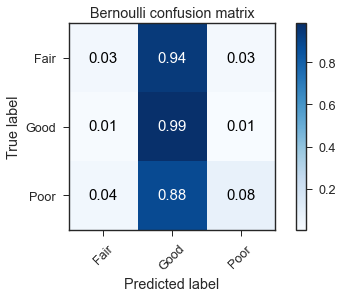

In [668]:
cm_bnb = confusion_matrix(y_test, y_pred_bnb)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm_bnb, classes,
                          normalize=True,
                          title='Bernoulli confusion matrix',
                          cmap=plt.cm.Blues)

In [639]:
# Create a params dictionary for a Bernoulli Naive Bayes classifier with prior probabilities of each class
params_nb = {
    'class_prior': [[0.1, 0.88, 0.02],[0.14, 0.82, 0.04], [0.175, 0.75, 0.075], [0.2, 0.7, 0.1]],
    'alpha': [.00001*10**i for i in range(5)],
}

In [640]:
#create a grid search object and fit it to the data
bnb_cv = BernoulliNB()
CV_bnb = GridSearchCV(bnb_cv, params_nb, scoring='f1_weighted', n_jobs=-1, verbose=2)
CV_bnb.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'class_prior': [[0.1, 0.88, 0.02], [0.14, 0.82, 0.04],
                                         [0.175, 0.75, 0.075],
                                         [0.2, 0.7, 0.1]]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [645]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(CV_bnb.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(CV_bnb.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(CV_bnb.best_estimator_)

0.39168838340099443
{'alpha': 0.01, 'class_prior': [0.2, 0.7, 0.1]}
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=[0.2, 0.7, 0.1],
            fit_prior=True)


In [646]:
#Predict the response for test dataset
y_pred_bnb_cv = CV_bnb.best_estimator_.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_bnb_cv))

# checking f1
print('Test F1 score: ', f1_score(y_test, y_pred_bnb_cv, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test, y_pred_bnb_cv, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test, y_pred_bnb_cv, average='weighted'))

Test Accuracy score:  0.8100870722843881
Test F1 score:  0.7494148927537303
Test Recall score:  0.8100870722843881
Test Precision score:  0.7293220666742322


Normalized confusion matrix
[[0.03549432 0.92621754 0.03828815]
 [0.01297489 0.9784997  0.00852541]
 [0.04317201 0.85798682 0.09884117]]


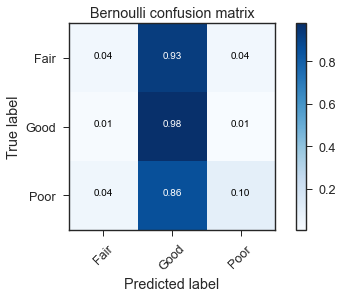

In [647]:
cm5 = confusion_matrix(y_test, y_pred_bnb_cv)
classes = ['Fair', 'Good', 'Poor']

plot_confusion_matrix(cm5, classes,
                          normalize=True,
                          title='Bernoulli confusion matrix',
                          cmap=plt.cm.Blues)

## Findings
* Species of tree is significant, Norway maple being the least good on average, and sawtooth oak being the most good.
    * I would recommend sticking to the healthier varieties in the graph created earlier, and avoiding the least healthy varieties.
* Problems with the tree itself were obviously significant.
    * Unfortunately, problems that were listed as “other” appear to hold the highest significance. In the next census, they should include columns with more specificity or a notes column (which one could feasibly process to create dummy variables).
    * I suggest conducting more regular maintenance, as well as pushing for environmental protections, in the style of the plastic ban bag.
* All levels of neighborhood delineation held significance.
    * I chose community board as my neighborhood variable in part because one must petition the community board to make changes to street trees.
* It's difficult to choose which model to use based off numbers alone. One must think carefully about how it is being used.
    * I went with a model that was more inaccurate but had a better spread of predictions. Not ready for primetime yet, but a step in the right direction.
* Many of the most prevalent features, including number of trees on block, distance to the nearest tree, and sidewalk damage, didn’t show much significance when looked at during EDA, but must have had solid predictive power after interacting with other branches of the Random Forest trees.

## Most prevalent features in the model (in order)
### Top features (out of 147):
     Tree diameter 			    (14.8%)
     Number of trees on block 	(11.2%)
     Distance to nearest tree 	(9.1%)
     Sidewalk damage 		    (7.6%)
     Tree stewards [1-2] 		(5.1%)
     Root problems [stone]      (4.8%)
     Species [Norway maple] 	(2.6%)
     Trunk problems [other] 	(2.4%)
     Branch problems [light] 	(2.2%)
     Species [London planetree] (2.0%)
     Branch problems [other] 	(2.0%)
     Community board [503] 	    (1.8%)
     Species [Honeylocust] 	    (1.3%)
     Borough [Queens] 		    (1.2%)



# Final conclusion
* I can run my final model on the data collected by volunteers and compile a list of trees that whose health statuses do not line up. In the meantime, the NYC Street Trees Census is fairly thorough and rife with opportunities for data exploration and predictive modeling. Perhaps with a neural network, I could greatly improve my model. In future censuses, even more data could be gathered (especially in regard to specificity) that will increase these opportunities for prediction even further.